## Introduction

Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination.

https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb

In [1]:
import palantir
import scanpy as sc
import numpy as np
import os
#pip install rpy2
# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Inline plotting
%matplotlib inline

# Reset random seed
np.random.seed(5)


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

##  Loading data

The data consists of a subset of 40K STAMP cells processed with the COSMX, exported as a h5ad.

## Subsample
to make it faster for testing purposes

In [3]:
# Load sample data
palantir_dir = "./h5ad/"
ad = sc.read(palantir_dir + 'stamp_subset_sorted_samples_corrected.h5ad')
#sc.pp.subsample(ad, fraction=0.20)
ad

AnnData object with n_obs × n_vars = 40202 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'cell_ID', 'cell', 'sample', 'sum', 'detected', 'altexps_negprobes_sum', 'altexps_negprobes_detected', 'altexps_negprobes_percent', 'altexps_falsecode_sum', 'altexps_falsecode_detected', 'altexps_falsecode_percent', 'total', 'fov_cell', 'label', 'unintegrated_clusters', 'seurat_clusters', 'barcode', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'palantir_clusters', 'Anno_270924', 'sample_corrected'
    var: 'gene_ID', 'colnames.X.'


NOTE: Counts are assumed to the normalized. If you have already normalized the data, skip past the Normalization section
## Data processing

### Normalization

Normalize the data for molecule count distribution using the scanpy interface


In [4]:
sc.pp.normalize_per_cell(ad)



We recommend that the data be log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale.

The function below uses a pseudocount of 0.1 instead of 1.


In [5]:
#palantir.preprocess.log_transform(ad)
sc.pp.log1p(ad)


Highly variable gene selection

Highly variable gene selection can also be performed using the scanpy interface


In [6]:
sc.pp.highly_variable_genes(ad, n_top_genes=300#, flavor='cell_ranger'
                           )

In [7]:
ad.var.highly_variable==True
ad.var.index = ad.var.gene_ID.values
ad.var

gene_ID colnames.X.  highly_variable     means  dispersions  \
AATK      AATK        AATK            False  0.321594     0.208843   
ABL1      ABL1        ABL1            False  1.584467     0.487590   
ABL2      ABL2        ABL2            False  0.981627     0.415924   
ACACB    ACACB       ACACB            False  0.133643     0.174712   
ACE        ACE         ACE            False  0.773909     0.461583   
...        ...         ...              ...       ...          ...   
XKR4      XKR4        XKR4            False  0.105299     0.217309   
YBX3      YBX3        YBX3            False  3.175849     1.166325   
YES1      YES1        YES1            False  1.650335     0.695623   
ZBTB16  ZBTB16      ZBTB16            False  0.251916     0.214505   
ZFP36    ZFP36       ZFP36            False  0.460296     0.311426   

        dispersions_norm  
AATK           -0.678512  
ABL1           -0.984480  
ABL2           -0.596649  
ACACB          -0.377546  
ACE            -0.550478  
...                  ...  
XKR4           -0.144364  
YBX3           -0.759469  
YES1           -0.766250  
ZBTB16         -0.663501  
ZFP36          -0.656239  

[1000 rows x 6 columns]

In [8]:
y = [i for i, x in enumerate(ad.var.highly_variable) if x]
hvg = ad.var.highly_variable[y].index
hvg

Index(['ACKR3', 'ACTA2', 'ACTG2', 'ADGRA2', 'ADGRE5', 'ADGRG1', 'ADGRG6',
       'ADGRV1', 'ALCAM', 'ANGPT2',
       ...
       'VCAM1', 'VEGFD', 'VIM', 'VTN', 'WNT11', 'WNT3', 'WNT5A', 'WNT5B',
       'WNT9A', 'XCL1/2'],
      dtype='object', length=300)

### PCA

PCA is the first step in data processing for Palantir. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data.

Rather than use a fixed number of PCs, we recommend the use of components that explain 85% of the variance in the data after highly variable gene selection.


In [9]:
sc.pp.pca(ad, n_comps = 30)

In [10]:
ad

AnnData object with n_obs × n_vars = 40202 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'cell_ID', 'cell', 'sample', 'sum', 'detected', 'altexps_negprobes_sum', 'altexps_negprobes_detected', 'altexps_negprobes_percent', 'altexps_falsecode_sum', 'altexps_falsecode_detected', 'altexps_falsecode_percent', 'total', 'fov_cell', 'label', 'unintegrated_clusters', 'seurat_clusters', 'barcode', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'palantir_clusters', 'Anno_270924', 'sample_corrected', 'n_counts'
    var: 'gene_ID', 'colnames.X.', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [11]:
ad.obs

orig.ident  nCount_RNA  nFeature_RNA  fov   Area  AspectRatio  \
c_1_35_420           c      2601.0         396.0   35  10925         1.11   
c_1_23_559           c      2972.0         466.0   23  16349         0.62   
c_1_40_118           c      2547.0         421.0   40  20239         0.95   
c_1_45_424           c      2317.0         405.0   45  13950         1.04   
c_1_5_786            c      5438.0         487.0    5  14177         0.86   
...                ...         ...           ...  ...    ...          ...   
c_1_636_255          c      4399.0         486.0  636  18712         0.80   
c_1_603_505          c      2150.0         363.0  603  11490         1.34   
c_1_635_196          c      5093.0         450.0  635  24702         0.93   
c_1_624_517          c      3949.0         457.0  624  14980         0.90   
c_1_628_555          c      4408.0         487.0  628  20208         1.38   

             CenterX_local_px  CenterY_local_px  cell_ID         cell  ...  \
c_1_35_420               3841              1651      420   c_1_35_420  ...   
c_1_23_559                823              1863      559   c_1_23_559  ...   
c_1_40_118               1044              1098      118   c_1_40_118  ...   
c_1_45_424               2525              1291      424   c_1_45_424  ...   
c_1_5_786                1982              3729      786    c_1_5_786  ...   
...                       ...               ...      ...          ...  ...   
c_1_636_255              2775               855      255  c_1_636_255  ...   
c_1_603_505              4129              3351      505  c_1_603_505  ...   
c_1_635_196              1037               698      196  c_1_635_196  ...   
c_1_624_517              1649              1865      517  c_1_624_517  ...   
c_1_628_555              1109              1703      555  c_1_628_555  ...   

            label  unintegrated_clusters  seurat_clusters      barcode  \
c_1_35_420      6                      3                1   c_1_35_420   
c_1_23_559      1                      3                0   c_1_23_559   
c_1_40_118      4                      3                1   c_1_40_118   
c_1_45_424      4                      3                2   c_1_45_424   
c_1_5_786       1                      3                0    c_1_5_786   
...           ...                    ...              ...          ...   
c_1_636_255     7                      2                2  c_1_636_255   
c_1_603_505     7                      2                0  c_1_603_505   
c_1_635_196     1                      2                2  c_1_635_196   
c_1_624_517     7                      2                2  c_1_624_517   
c_1_628_555     7                      2                2  c_1_628_555   

             RNA_snn_res.0.1  RNA_snn_res.0.2  palantir_clusters  Anno_270924  \
c_1_35_420                 0                1                  2  Pluripotent   
c_1_23_559                 0                0                  2  Pluripotent   
c_1_40_118                 0                1                  2  Pluripotent   
c_1_45_424                 0                2                  2  Pluripotent   
c_1_5_786                  0                0                  2  Pluripotent   
...                      ...              ...                ...          ...   
c_1_636_255                0                2                  6      MesEndo   
c_1_603_505                0                0                  6      MesEndo   
c_1_635_196                0                2                  2  Pluripotent   
c_1_624_517                0                2                  6      MesEndo   
c_1_628_555                0                2                  6      MesEndo   

             sample_corrected  n_counts  
c_1_35_420           iESC_24h    2601.0  
c_1_23_559           iESC_24h    2972.0  
c_1_40_118           iESC_24h    2547.0  
c_1_45_424           iESC_24h    2317.0  
c_1_5_786            iESC_24h    5438.0  
...                       ...       

In [12]:
pca_projections = pd.DataFrame(data=ad.obsm['X_pca'],   # values
                               index=ad.obs.index)    # 1st row as the column names

In [13]:
pca_projections

0         1         2         3         4         5   \
c_1_35_420  -4.702613 -0.357401 -1.407568 -0.124809 -0.123799 -0.255499   
c_1_23_559  -3.202265  0.012422 -0.722481 -1.765821 -0.345770  3.066309   
c_1_40_118  -4.101745 -0.483805 -1.060464  0.974543  0.627037  0.697205   
c_1_45_424  -4.483529 -1.088474 -1.620894 -0.136415 -0.518022 -0.365347   
c_1_5_786   -4.061803 -0.272964 -0.107678 -0.686736 -0.634968  0.211251   
...               ...       ...       ...       ...       ...       ...   
c_1_636_255 -3.225631 -0.813409  1.210203  0.810805  0.310741  1.946528   
c_1_603_505 -3.484164 -0.899884  1.671508  0.375361 -1.050192 -0.798108   
c_1_635_196 -4.151984 -1.164292 -0.655534 -0.480116 -0.526220 -0.695567   
c_1_624_517 -3.331639  0.963626  1.184238 -1.325895 -0.379843  0.900199   
c_1_628_555 -4.676505 -1.478089 -0.047116 -0.380970 -0.614253 -0.062052   

                   6         7         8         9   ...        20        21  \
c_1_35_420   0.373492 -0.245275 -0.827834  1.030323  ...  0.086169  0.508352   
c_1_23_559   0.613816  0.295527 -0.540425  0.262520  ...  0.351659  1.410873   
c_1_40_118   0.972646  0.003948 -0.504303 -0.913779  ... -0.595649  0.742972   
c_1_45_424   1.796028 -1.020722  0.409511 -0.493881  ...  0.017533  0.697902   
c_1_5_786    0.889364 -0.242246  0.002496  0.330137  ...  0.062166  0.536211   
...               ...       ...       ...       ...  ...       ...       ...   
c_1_636_255 -0.019216 -1.670170 -0.585391 -0.473289  ... -0.763669  0.174804   
c_1_603_505  3.485273  0.619074 -1.149612 -0.258012  ...  1.099015  0.057270   
c_1_635_196  1.779132 -0.902444  0.316190 -1.243642  ...  0.321054  0.497353   
c_1_624_517  2.201625 -1.678025 -1.107739 -0.199247  ... -0.014241  1.244130   
c_1_628_555  1.236717 -0.555138 -0.772640 -0.949789  ... -0.320833 -0.216235   

                   22        23        24        25        26        27  \
c_1_35_420  -1.551326  0.090290 -0.109323  0.228670 -0.493916 -0.354815   
c_1_23_559  -0.355028  0.259186  0.700351 -0.280762  0.488106  1.399018   
c_1_40_118   0.626246 -0.070478  1.727390  0.534821 -0.745077  0.261997   
c_1_45_424   0.542004 -0.441676  0.305167 -0.575196 -1.231687  0.403437   
c_1_5_786   -0.721672 -0.799448  0.036294 -0.513760 -0.672208 -0.297856   
...               ...       ...       ...       ...       ...       ...   
c_1_636_255 -0.406506  0.861379  0.132912 -0.457506  0.262597 -0.112094   
c_1_603_505  0.199538  0.641605  0.310694  0.991280  0.026633  0.630063   
c_1_635_196  0.589067  0.791166 -0.097789  0.079702  0.238076 -0.324946   
c_1_624_517 -0.428942 -0.285359  0.326468  0.383053 -0.016579 -0.706798   
c_1_628_555  0.251653  0.513463  0.508208 -0.737374 -0.185674 -0.315898   

                   28        29  
c_1_35_420   0.244195  0.680989  
c_1_23_559  -0.353317  0.094231  
c_1_40_118   0.530999  1.513772  
c_1_45_424  -0.513116  0.204120  
c_1_5_786    0.019956 -0.894640  
...               ...       ...  
c_1_636_255  0.044793  0.037385  
c_1_603_505  0.536832 -1.184023  
c_1_635_196  0.285421  0.491037  
c_1_624_517  0.731852 -0.081217  
c_1_628_555  0.058679  0.742230  

[40202 rows x 30 columns]

## Harmony augmented affinity matrix

The following metadata information is necessary for Harmony

1.    Timepoint at which each cell was measured
2.    Connections between timepoints for computation of mutually nearest neighbors



In [14]:
tp = pd.Series(data =ad.obs['sample_corrected'], index=ad.obs['sample_corrected'].index)
tp

c_1_35_420     iESC_24h
c_1_23_559     iESC_24h
c_1_40_118     iESC_24h
c_1_45_424     iESC_24h
c_1_5_786      iESC_24h
                 ...   
c_1_636_255    iESC_48h
c_1_603_505    iESC_48h
c_1_635_196    iESC_48h
c_1_624_517    iESC_48h
c_1_628_555    iESC_48h
Name: sample_corrected, Length: 40202, dtype: category
Categories (8, object): ['iESC_0h' < 'iESC_6h' < 'iESC_12h' < 'iESC_24h' < 'iESC_48h' < 'iESC_72h' < 'iESC_96h' < 'iESC_120h']

In [15]:
timepoint_connections = pd.DataFrame(columns=[0,1])
index = 0
timepoint_connections.loc[index, :] = ['iESC_0h', 'iESC_6h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_6h', 'iESC_12h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_12h', 'iESC_24h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_24h', 'iESC_48h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_48h', 'iESC_72h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_72h', 'iESC_96h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_96h', 'iESC_120h']; index += 1


timepoint_connections

0          1
0   iESC_0h    iESC_6h
1   iESC_6h   iESC_12h
2  iESC_12h   iESC_24h
3  iESC_24h   iESC_48h
4  iESC_48h   iESC_72h
5  iESC_72h   iESC_96h
6  iESC_96h  iESC_120h

In [16]:
data_df = pd.DataFrame(data=ad.X,   # values
                       index=ad.obs.index,
                       columns= ad.var.index
                      )    # 1st row as the column names

In [17]:
data_df

AATK      ABL1      ABL2  ACACB       ACE     ACKR1  \
c_1_35_420   0.760601  2.314167  0.760601    0.0  0.760601  0.000000   
c_1_23_559   0.000000  2.077084  1.384274    0.0  0.000000  0.000000   
c_1_40_118   0.771830  1.732520  1.202204    0.0  1.502112  0.000000   
c_1_45_424   0.823842  0.823842  0.823842    0.0  1.269334  0.000000   
c_1_5_786    0.435058  1.945279  0.000000    0.0  0.435058  0.000000   
...               ...       ...       ...    ...       ...       ...   
c_1_636_255  0.000000  2.046130  1.105710    0.0  0.853385  0.515090   
c_1_603_505  0.866514  1.323676  1.323676    0.0  0.866514  0.000000   
c_1_635_196  0.000000  1.502265  1.363506    0.0  0.000000  0.000000   
c_1_624_517  0.916746  1.558744  0.559941    0.0  0.559941  0.000000   
c_1_628_555  0.000000  1.853060  0.514268    0.0  0.514268  0.514268   

                ACKR3     ACKR4      ACP5  ACTA2  ...     WNT7A     WNT7B  \
c_1_35_420   0.760601  0.000000  0.000000    0.0  ...  1.187576  0.000000   
c_1_23_559   0.000000  0.691800  0.691800    0.0  ...  0.000000  0.000000   
c_1_40_118   0.000000  0.771830  1.202204    0.0  ...  0.771830  0.000000   
c_1_45_424   0.000000  0.000000  0.823842    0.0  ...  0.000000  0.000000   
c_1_5_786    0.000000  0.737215  0.000000    0.0  ...  0.000000  0.435058   
...               ...       ...       ...    ...  ...       ...       ...   
c_1_636_255  0.000000  0.515090  0.000000    0.0  ...  0.000000  0.000000   
c_1_603_505  0.000000  0.000000  0.000000    0.0  ...  0.866514  0.000000   
c_1_635_196  0.000000  0.000000  0.000000    0.0  ...  0.458674  0.000000   
c_1_624_517  0.559941  0.000000  1.386864    0.0  ...  0.000000  0.000000   
c_1_628_555  0.514268  0.000000  1.305533    0.0  ...  0.000000  0.000000   

                WNT9A      XBP1  XCL1/2      XKR4      YBX3      YES1  \
c_1_35_420   0.000000  1.485842     0.0  0.000000  2.760915  1.187576   
c_1_23_559   0.000000  2.300159     0.0  0.000000  3.463125  1.789514   
c_1_40_118   0.000000  1.732520     0.0  0.000000  2.780581  0.000000   
c_1_45_424   1.269334  2.418938     0.0  0.823842  3.978725  1.576444   
c_1_5_786    0.000000  2.020307     0.0  0.000000  3.415524  0.737215   
...               ...       ...     ...       ...       ...       ...   
c_1_636_255  0.000000  2.046130     0.0  0.515090  3.116235  2.206677   
c_1_603_505  0.000000  2.365582     0.0  0.000000  3.352430  1.874018   
c_1_635_196  0.000000  1.830624     0.0  0.000000  3.745265  1.830624   
c_1_624_517  0.000000  1.833219     0.0  0.000000  2.983875  1.558744   
c_1_628_555  0.000000  1.853060     0.0  0.514268  3.671926  1.853060   

               ZBTB16     ZFP36  
c_1_35_420   0.000000  0.000000  
c_1_23_559   0.000000  0.000000  
c_1_40_118   0.000000  0.000000  
c_1_45_424   0.823842  0.000000  
c_1_5_786    0.000000  0.968944  
...               ...       ...  
c_1_636_255  0.000000  0.000000  
c_1_603_505  0.866514  0.000000  
c_1_635_196  0.458674  0.458674  
c_1_624_517  0.000000  0.916746  
c_1_628_555  0.000000  0.000000  

[40202 rows x 1000 columns]

Using the above information, the augmented and non-augmented affinity matrices can be computed using


In [18]:
import harmony
aug_aff, aff = harmony.core.augmented_affinity_matrix(pca_projections, tp,
                                                      timepoint_connections, pc_components= 10)

Running PCA with 10 components
Nearest neighbor computation...


/home/irepan/anaconda3/envs/py38/lib/python3.8/site-packages/harmony/core.py:70: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  kNN = temp.uns['neighbors']['distances']


Constucting affinities between iESC_0h and iESC_6h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_6h and iESC_12h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_12h and iESC_24h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_24h and iESC_48h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_48h and iESC_72h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_72h and iESC_96h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_96h and iESC_120h...
t+1 neighbors of t...
t neighbors of t+1...


In [19]:
# layout = harmony.plot.force_directed_layout(aug_aff, data_df.index, iterations= 200)
# layout.to_csv("dfl_palantir_coords_oct24.csv")

In [20]:
# import the already computed coords
layout = pd.read_csv("./csv/dfl_palantir_coords_oct24.csv", index_col = 0)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


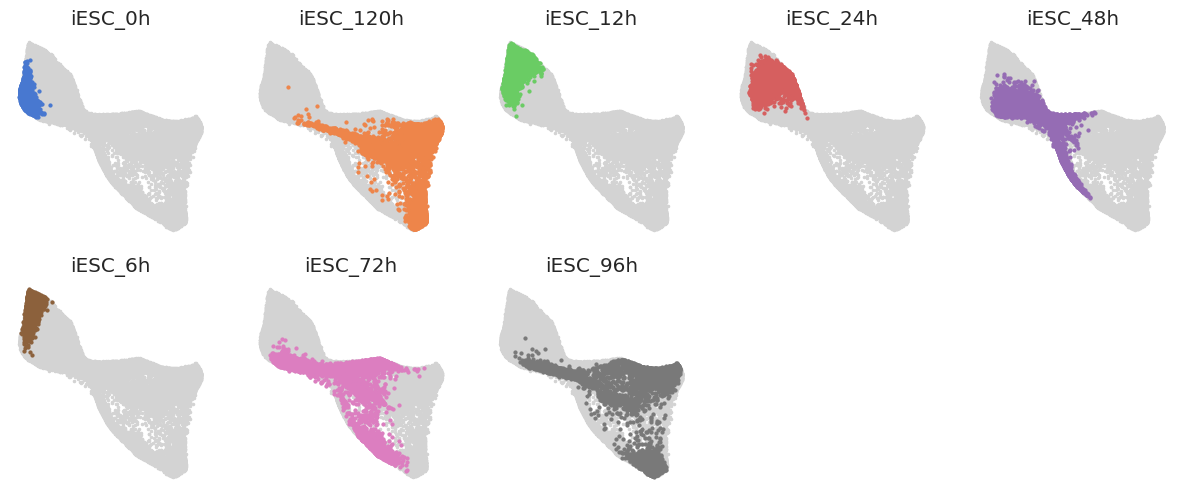

In [21]:
harmony.plot.plot_timepoints(layout, tp)

In [22]:
dm_res = palantir.utils.run_diffusion_maps(aug_aff)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [23]:
ad.obsm["X_dfl"] = layout.to_numpy()

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


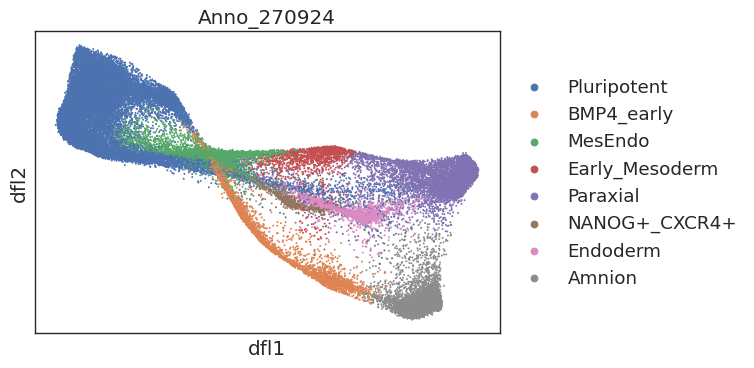

In [24]:
sc.pl.embedding(ad, basis="dfl", color="Anno_270924", size=8)

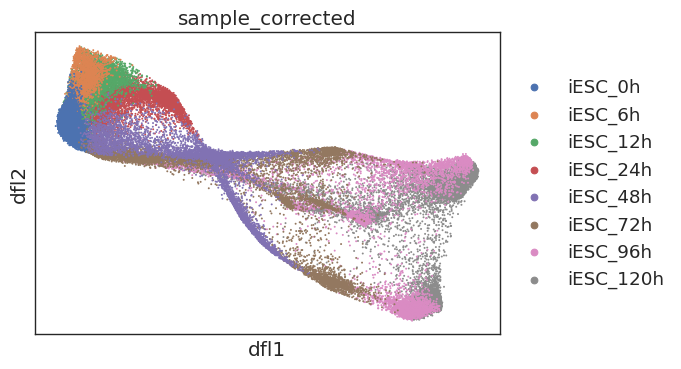

In [25]:
sc.pl.embedding(ad, basis="dfl", color="sample_corrected", size=8)

In [26]:
color = dict(zip(range(0,15), plt.cm.tab20(range(0,15))))

In [27]:
clusters = palantir.utils.determine_cell_clusters(pca_projections)

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 23.316383123397827 seconds
Jaccard graph constructed in 3.927112340927124 seconds
Wrote graph to binary file in 0.8296008110046387 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.843478
Louvain completed 21 runs in 26.68843388557434 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 55.10273838043213 seconds


In [28]:
# read preprocessed data
ad =  sc.read(filename="./h5ad/stamp_subset_sorted_dfl_Oct2024.h5ad")
clusters = ad.obs["palantir_clusters"]

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


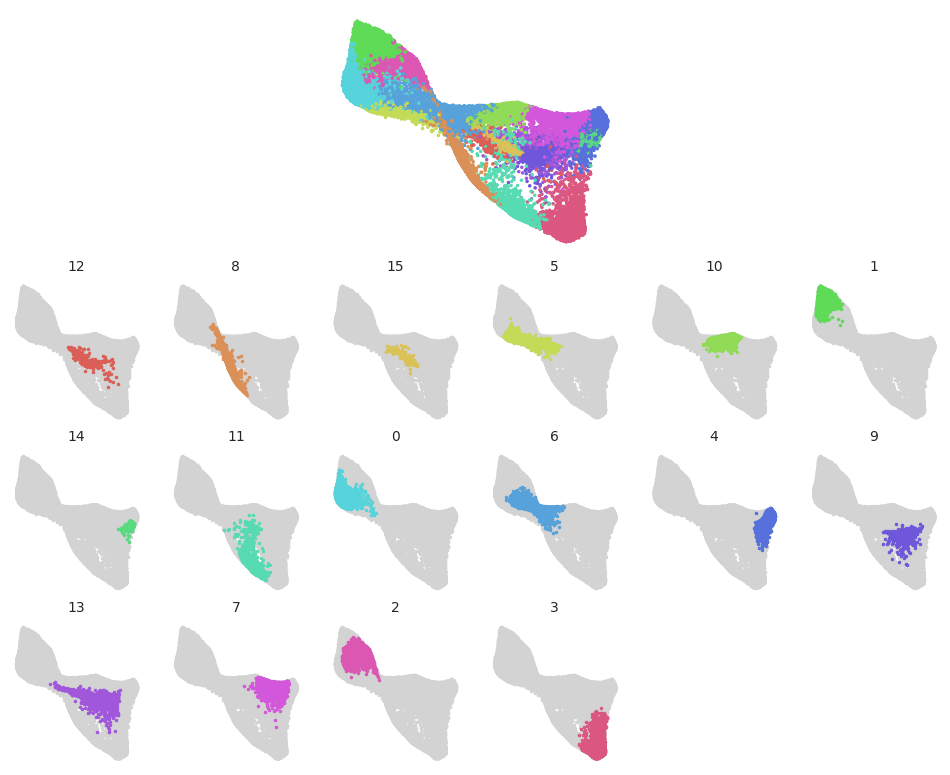

In [29]:
palantir.plot.plot_cell_clusters(layout, clusters )

In [30]:
imp_X = palantir.utils.run_magic_imputation(data_df, dm_res)

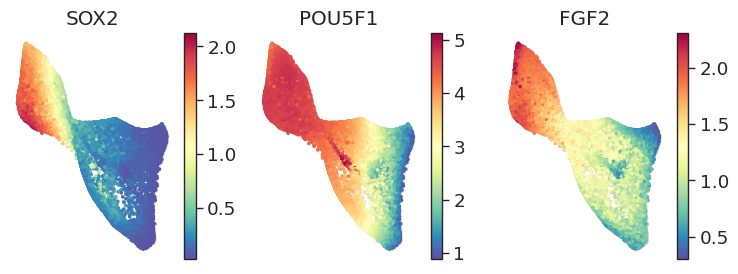

In [31]:
palantir.plot.plot_gene_expression(imp_X, layout, ['SOX2', "POU5F1","FGF2"], {"s": 1})

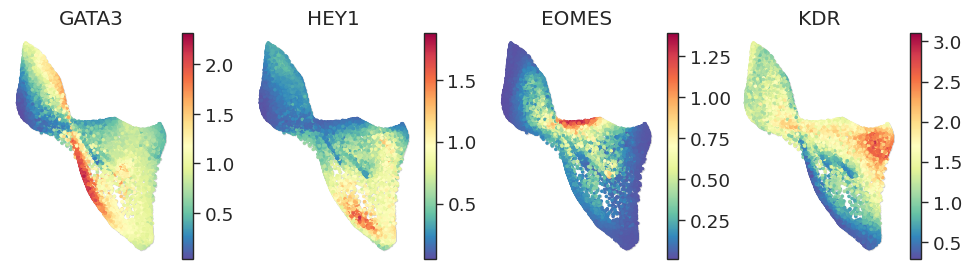

In [32]:
palantir.plot.plot_gene_expression(imp_X, layout, ['GATA3', "HEY1",'EOMES', "KDR"], {"s": 1})

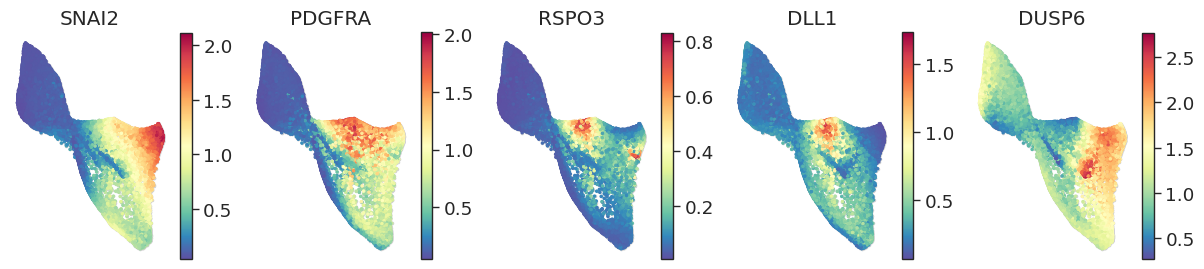

In [33]:
palantir.plot.plot_gene_expression(imp_X, layout, [ "SNAI2", "PDGFRA","RSPO3", "DLL1", "DUSP6"], {"s": 1})

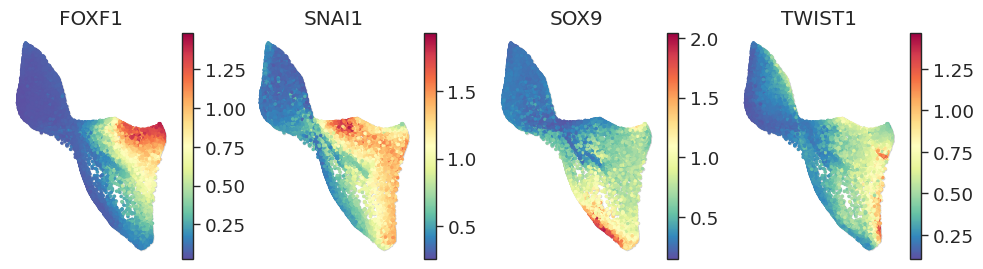

In [34]:
 palantir.plot.plot_gene_expression(imp_X, layout, ["FOXF1", "SNAI1","SOX9", "TWIST1"], {"s": 1})

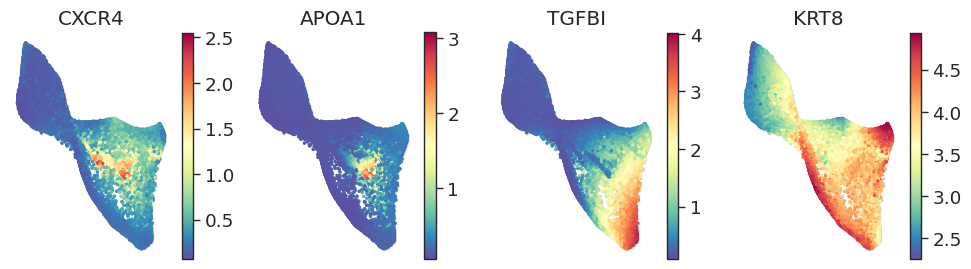

In [35]:
 palantir.plot.plot_gene_expression(imp_X, layout, ["CXCR4", "APOA1","TGFBI", "KRT8"], {"s": 1})

In [36]:
column = layout["y"]
max_value = column.idxmax()
min_value = column.idxmin()
column = layout["x"]
max_xval  = column.idxmax()
min_xval =  column.idxmin()


In [37]:
column = imp_X["KRT8"]
max_KRT8 = column.idxmax()
max_KRT8
column = imp_X["TGFB1"]
max_TGFB1 = column.idxmax()
max_TGFB1
column = imp_X["DUSP6"]
max_DUSP6 = column.idxmax()
max_DUSP6
column = imp_X["APOA1"]
max_APOA1 = column.idxmax()
max_APOA1

'c_1_78_1113'

In [38]:
column.sort_values(ascending=False)

c_1_78_1113     3.070614
c_1_90_545      3.067263
c_1_114_803     3.047277
c_1_82_1085     3.039881
c_1_66_620      3.020795
                  ...   
c_1_646_386     0.063903
c_1_354_626     0.063411
c_1_336_751     0.063042
c_1_614_100     0.061639
c_1_651_1139    0.060528
Name: APOA1, Length: 40202, dtype: float64

In [39]:
#max_Gata6 = "hj7jvltq_83oxwg2o_CCATAAATCAGCAAAG-1"

In [40]:

Mesoderm = max_KRT8
Endoderm = max_APOA1
Amnion = min_value

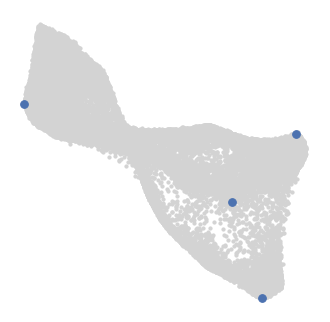

In [41]:
cells = [min_xval,Mesoderm, Endoderm, Amnion]

#palantir.plot.plot_terminal_state_probs(pr_res, cells)
palantir.plot.highlight_cells_on_tsne(layout, cells)
plt.savefig('cells.jpeg', bbox_inches='tight', dpi = 900)

##  Running Palantir

Palantir can be run by specifying an approxiate early cell.

Palantir can automatically determine the terminal states as well. In this dataset, we know the terminal states and we will set them using the terminal_states parameter

The start cell for this dataset was chosen based on high expression of CD34.


In [42]:
terminal_states = pd.Series(['Mesoderm', "Endoderm", "Amnion"], 
                           index=[Mesoderm, Endoderm, Amnion])
start_cell = min_xval

In [43]:
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.022453920046488444 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.4083325823148092 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9992
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


### Palantir generates the following results

1.    Pseudotime: Pseudo time ordering of each cell
2.    Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
3.    Entropy: A quantiative measure of the differentiation potential of each cell computed as the entropy of the multinomial terminal state probabilities

The terminal states in this dataset are renamed to reflect the known biology below


In [44]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

## Visualizing Palantir results

Palantir results can be visualized on the tSNE map using the plot_palantir_results function


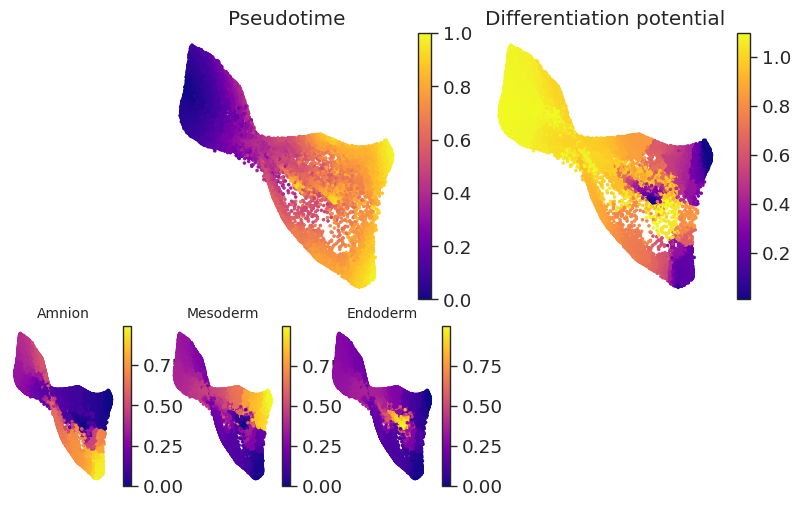

In [45]:
palantir.plot.plot_palantir_results(pr_res, layout)

### Gene expression trends

Palantir uses Generalized Additive Models (GAMs) to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the lineages parameter.


In [46]:
goi = ["SOX2",   #"POU5F1", 
       "FOXF1", "APOA1","TGFBI", "KDR" ]
data_goi = data_df.loc[:,goi]
data_goi
imp_goi = palantir.utils.run_magic_imputation(data_goi, dm_res)

In [47]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_goi.loc[:, goi])

Amnion
Time for processing Amnion: 0.052115257581075033 minutes
Mesoderm
Time for processing Mesoderm: 0.03826384544372559 minutes
Endoderm
Time for processing Endoderm: 0.01596309741338094 minutes



The determined trends can be visualized with the plot_gene_trends function. A separate panel is generated for each gene


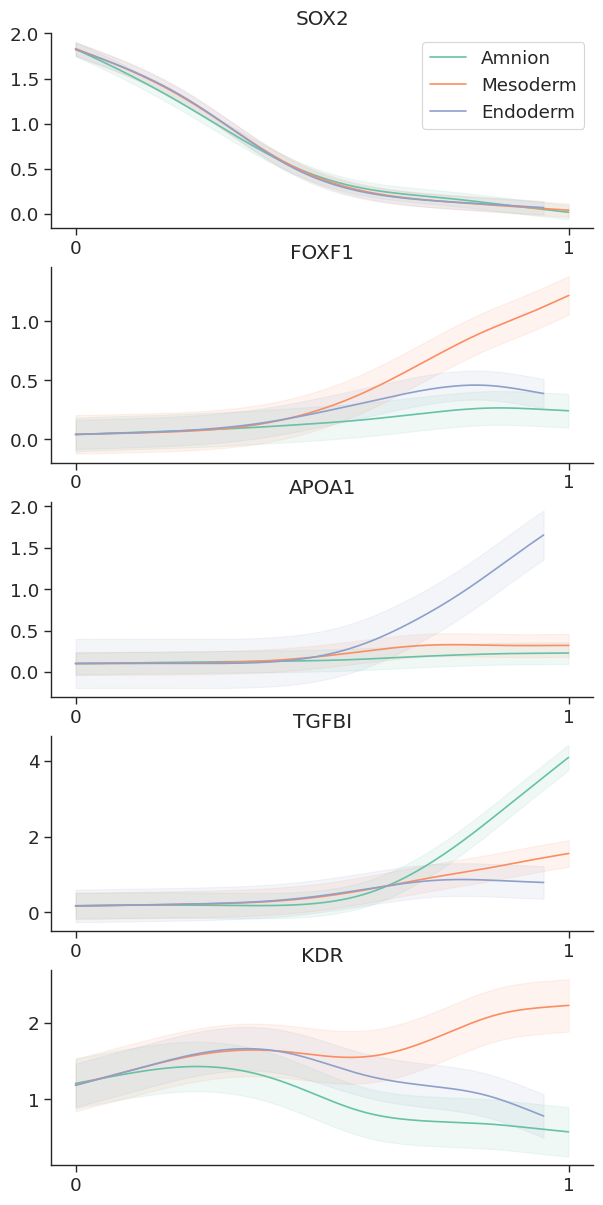

In [48]:
palantir.plot.plot_gene_trends(gene_trends)
#plt.savefig('foo.svg', bbox_inches='tight')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


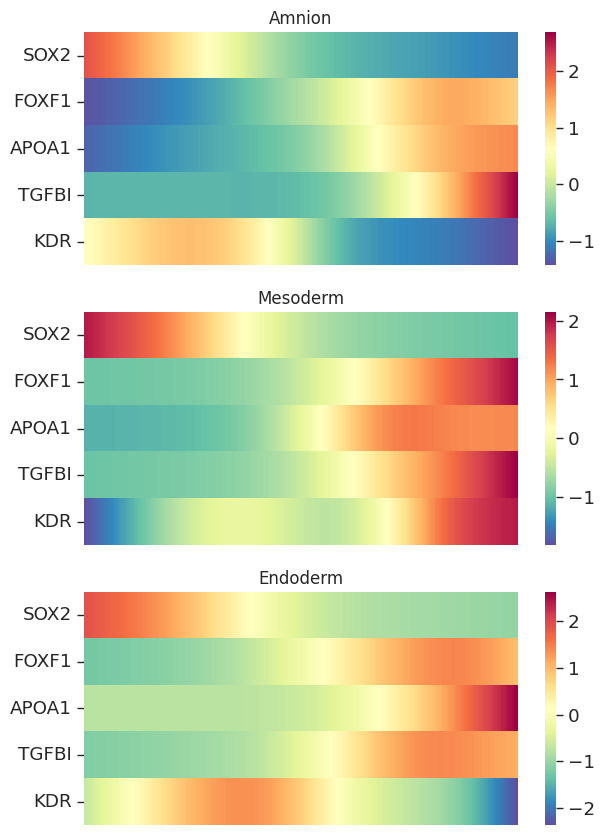

In [49]:
palantir.plot.plot_gene_trend_heatmaps(gene_trends)

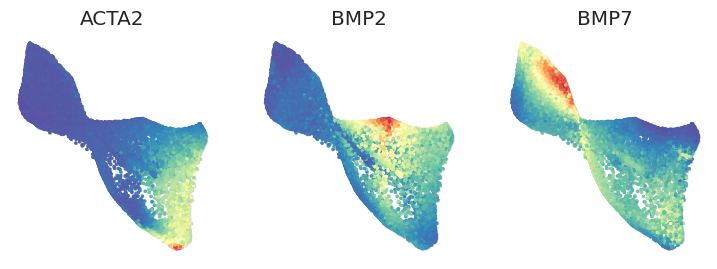

In [50]:
palantir.plot.plot_gene_expression(imp_X, layout, ["ACTA2", "BMP2", "BMP7"])

## Clustering

In [51]:
clusters

c_1_35_420     2
c_1_23_559     2
c_1_40_118     2
c_1_45_424     2
c_1_5_786      2
              ..
c_1_636_255    6
c_1_603_505    6
c_1_635_196    2
c_1_624_517    6
c_1_628_555    6
Name: palantir_clusters, Length: 40202, dtype: category
Categories (16, object): ['0', '1', '10', '11', ..., '6', '7', '8', '9']

In [52]:
x =pd.Series(data =clusters.astype("str"), index=ad.obs["sample_corrected"].index)
ad.obs["palantir_clusters"] = x

In [53]:
ad.obs.palantir_clusters = ad.obs.palantir_clusters.astype("str")

In [54]:
ad.obs.palantir_clusters = ad.obs.palantir_clusters.astype("category")

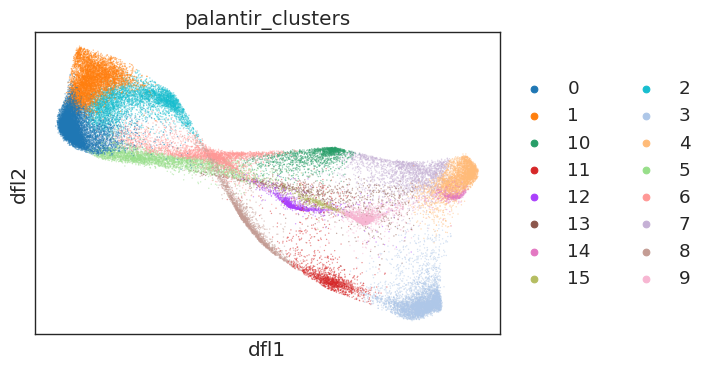

In [55]:
sc.pl.embedding(ad, basis="dfl", color="palantir_clusters", size=4, alpha= 0.5)

In [56]:
sc.tl.rank_genes_groups(ad, groupby="palantir_clusters",use_raw=False)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


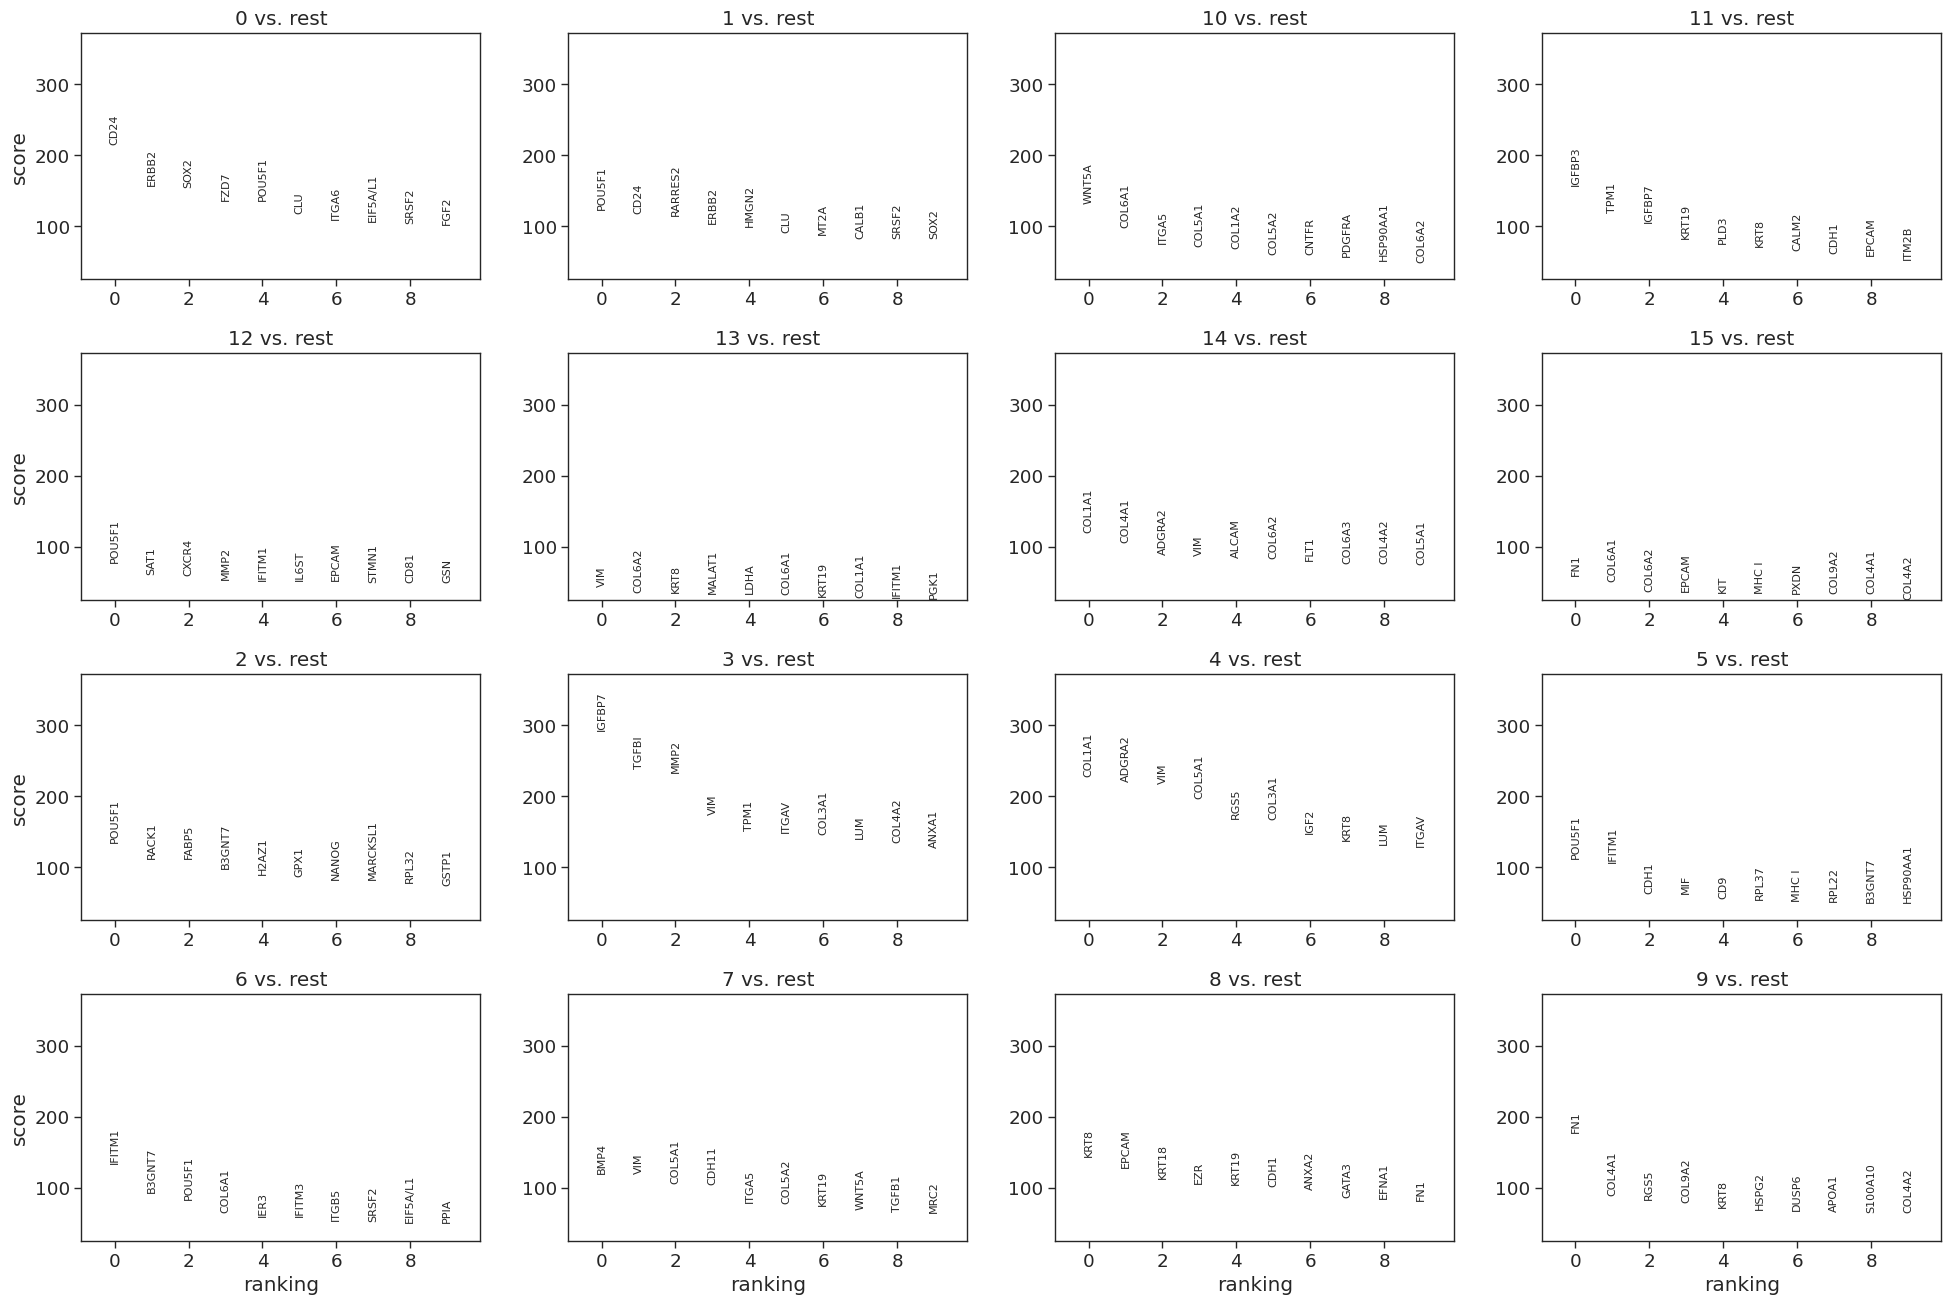

In [57]:
sc.pl.rank_genes_groups(ad, n_genes=10)

ad.X.columns[[18779,15920,19958,13360,6300,32199,27460,21508,7865]]

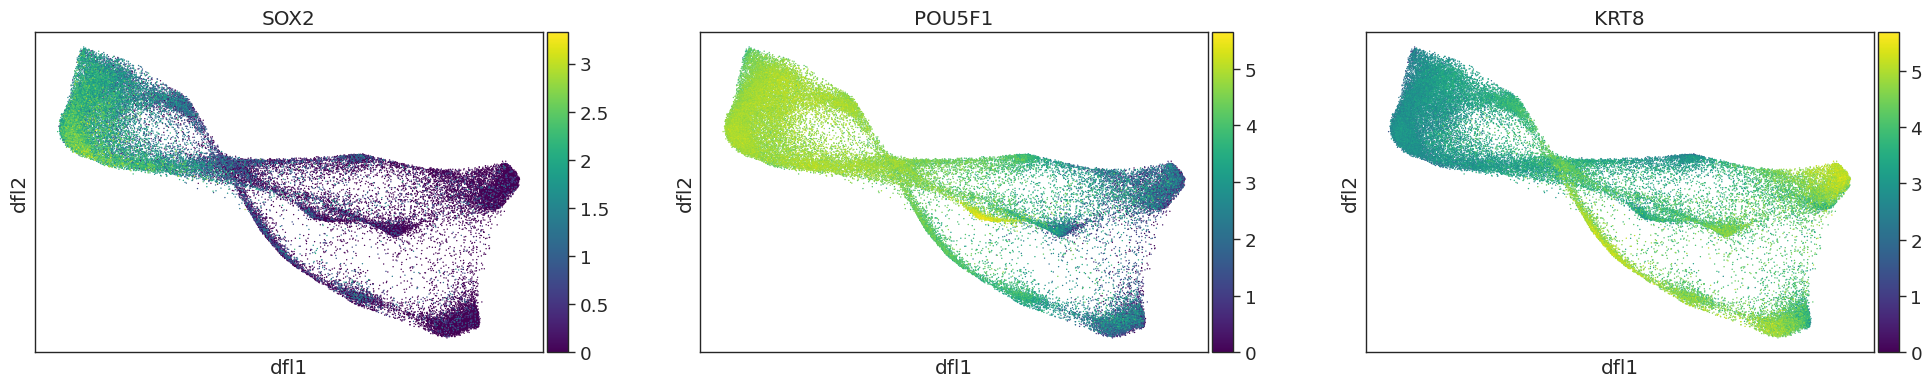

In [58]:
#cluster 0 - 2
sc.pl.scatter(ad, basis="dfl",
              color=['SOX2', 'POU5F1', 'KRT8'],
              use_raw=False,size = 4, color_map="viridis" )

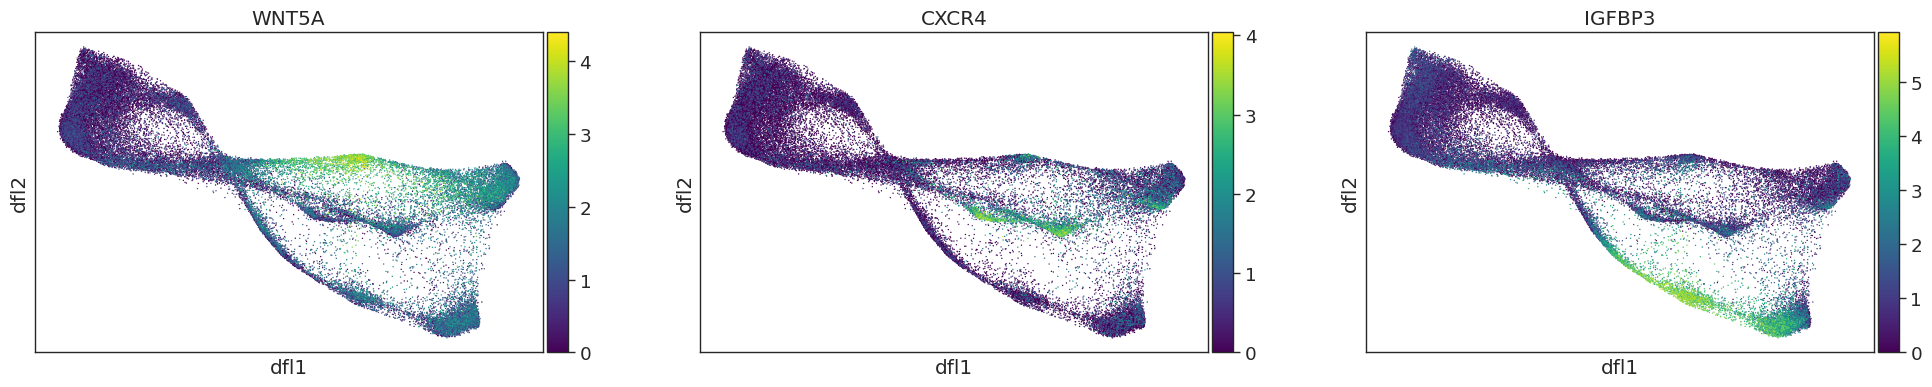

In [59]:
#cluster 3-5
sc.pl.scatter(ad, basis="dfl",
              color=['WNT5A', 'CXCR4', "IGFBP3"],
              use_raw=False,size = 4 , color_map="viridis")

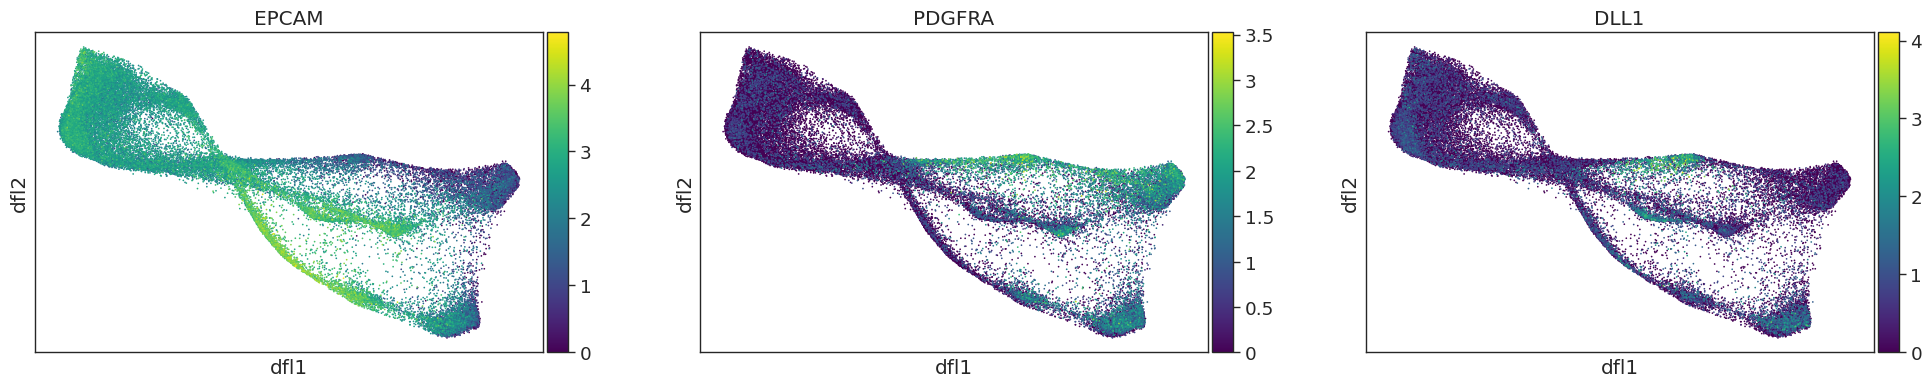

In [60]:
#cluster 6-8
sc.pl.scatter(ad, basis="dfl",
              color=[ 'EPCAM','PDGFRA', "DLL1"],
              use_raw=False,size = 6, color_map="viridis" )

In [61]:
ad

AnnData object with n_obs × n_vars = 40202 × 1000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'cell_ID', 'cell', 'sample', 'sum', 'detected', 'altexps_negprobes_sum', 'altexps_negprobes_detected', 'altexps_negprobes_percent', 'altexps_falsecode_sum', 'altexps_falsecode_detected', 'altexps_falsecode_percent', 'total', 'fov_cell', 'label', 'unintegrated_clusters', 'seurat_clusters', 'barcode', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'palantir_clusters', 'Anno_270924', 'sample_corrected', 'n_counts'
    var: 'gene_ID', 'colnames.X.', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Anno_270924_colors', 'RNA_snn_res.0.1_colors', 'dendrogram_palantir_clusters', 'hvg', 'neighbors', 'palantir_clusters_colors', 'pca', 'rank_genes_groups', 'sample_colors', 'sample_corrected_colors', 'umap'
    obsm: 'X_dfl', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [62]:
layout

x             y
c_1_35_420  -23931.585468   6912.101448
c_1_23_559  -13116.700237  10812.324828
c_1_40_118  -20641.017006   6155.907144
c_1_45_424  -20914.766668   6912.480744
c_1_5_786   -18924.026832   8467.443352
...                   ...           ...
c_1_636_255  -7276.481355   1618.748983
c_1_603_505  -1771.341349   1653.476673
c_1_635_196 -19796.310039   5866.158415
c_1_624_517  -8430.754006   3655.937271
c_1_628_555 -16673.638420   4346.983826

[40202 rows x 2 columns]

In [63]:
#np.savetxt("dfl_palantir_oct24.csv", layout, delimiter=",")

In [64]:
layout.index

Index(['c_1_35_420', 'c_1_23_559', 'c_1_40_118', 'c_1_45_424', 'c_1_5_786',
       'c_1_35_981', 'c_1_61_67', 'c_1_20_1144', 'c_1_5_371', 'c_1_46_34',
       ...
       'c_1_651_738', 'c_1_633_853', 'c_1_619_640', 'c_1_648_652',
       'c_1_626_34', 'c_1_636_255', 'c_1_603_505', 'c_1_635_196',
       'c_1_624_517', 'c_1_628_555'],
      dtype='object', length=40202)

In [65]:
ad.obs

orig.ident  nCount_RNA  nFeature_RNA  fov   Area  AspectRatio  \
c_1_35_420           c      2601.0         396.0   35  10925         1.11   
c_1_23_559           c      2972.0         466.0   23  16349         0.62   
c_1_40_118           c      2547.0         421.0   40  20239         0.95   
c_1_45_424           c      2317.0         405.0   45  13950         1.04   
c_1_5_786            c      5438.0         487.0    5  14177         0.86   
...                ...         ...           ...  ...    ...          ...   
c_1_636_255          c      4399.0         486.0  636  18712         0.80   
c_1_603_505          c      2150.0         363.0  603  11490         1.34   
c_1_635_196          c      5093.0         450.0  635  24702         0.93   
c_1_624_517          c      3949.0         457.0  624  14980         0.90   
c_1_628_555          c      4408.0         487.0  628  20208         1.38   

             CenterX_local_px  CenterY_local_px  cell_ID         cell  ...  \
c_1_35_420               3841              1651      420   c_1_35_420  ...   
c_1_23_559                823              1863      559   c_1_23_559  ...   
c_1_40_118               1044              1098      118   c_1_40_118  ...   
c_1_45_424               2525              1291      424   c_1_45_424  ...   
c_1_5_786                1982              3729      786    c_1_5_786  ...   
...                       ...               ...      ...          ...  ...   
c_1_636_255              2775               855      255  c_1_636_255  ...   
c_1_603_505              4129              3351      505  c_1_603_505  ...   
c_1_635_196              1037               698      196  c_1_635_196  ...   
c_1_624_517              1649              1865      517  c_1_624_517  ...   
c_1_628_555              1109              1703      555  c_1_628_555  ...   

            label  unintegrated_clusters  seurat_clusters      barcode  \
c_1_35_420      6                      3                1   c_1_35_420   
c_1_23_559      1                      3                0   c_1_23_559   
c_1_40_118      4                      3                1   c_1_40_118   
c_1_45_424      4                      3                2   c_1_45_424   
c_1_5_786       1                      3                0    c_1_5_786   
...           ...                    ...              ...          ...   
c_1_636_255     7                      2                2  c_1_636_255   
c_1_603_505     7                      2                0  c_1_603_505   
c_1_635_196     1                      2                2  c_1_635_196   
c_1_624_517     7                      2                2  c_1_624_517   
c_1_628_555     7                      2                2  c_1_628_555   

             RNA_snn_res.0.1  RNA_snn_res.0.2  palantir_clusters  Anno_270924  \
c_1_35_420                 0                1                  2  Pluripotent   
c_1_23_559                 0                0                  2  Pluripotent   
c_1_40_118                 0                1                  2  Pluripotent   
c_1_45_424                 0                2                  2  Pluripotent   
c_1_5_786                  0                0                  2  Pluripotent   
...                      ...              ...                ...          ...   
c_1_636_255                0                2                  6      MesEndo   
c_1_603_505                0                0                  6      MesEndo   
c_1_635_196                0                2                  2  Pluripotent   
c_1_624_517                0                2                  6      MesEndo   
c_1_628_555                0                2                  6      MesEndo   

             sample_corrected  n_counts  
c_1_35_420           iESC_24h    2601.0  
c_1_23_559           iESC_24h    2972.0  
c_1_40_118           iESC_24h    2547.0  
c_1_45_424           iESC_24h    2317.0  
c_1_5_786            iESC_24h    5438.0  
...                       ...       

In [66]:
#layout.to_csv("dfl_palantir_coords_oct24.csv")

In [67]:
#ad.obs.to_csv("dfl_palantir_metadata_oct24.csv")

In [68]:
#ad.write(filename="stamp_subset_sorted_dfl_Oct2024.h5ad")